In [3]:
import sys
import os
sys.path.append(os.path.dirname(os.getcwd()))

In [4]:
import bartz
from stochtree import BARTModel
from bart_playground import *

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import arviz as az
import time

INFO:arviz.preview:arviz_base not installed
INFO:arviz.preview:arviz_stats not installed
INFO:arviz.preview:arviz_plots not installed


In [6]:
import numpy as np

from sklearn.datasets import fetch_california_housing

data = fetch_california_housing(as_frame=True)

X = data.data
y = data.target

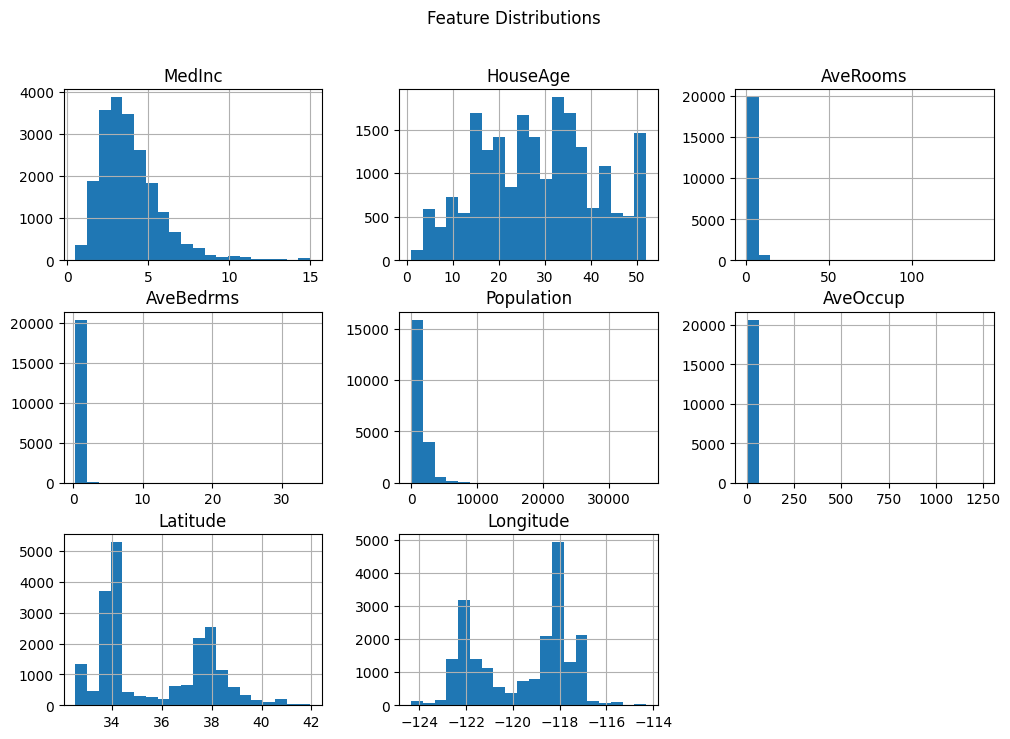

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

X.hist(figsize=(12, 8), bins=20)
plt.suptitle("Feature Distributions")
plt.show()

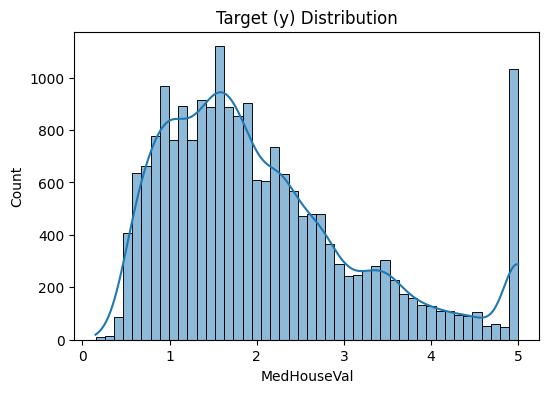

In [8]:
plt.figure(figsize=(6, 4))
sns.histplot(y, kde=True)
plt.title("Target (y) Distribution")
plt.show()

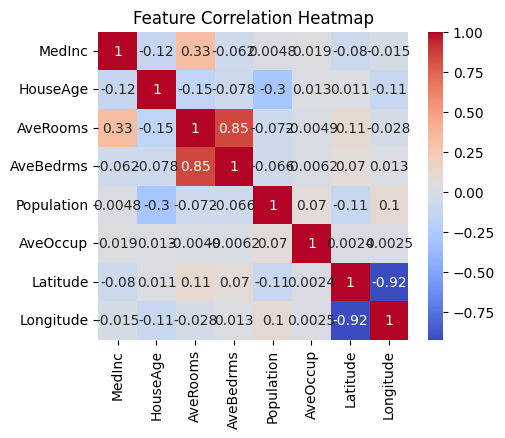

In [9]:
plt.figure(figsize=(5, 4))
corr = X.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()

In [10]:
X = X.values.astype(float)
y = np.array(y).reshape(-1)

In [18]:
import comparison
import pandas as pd

rhat_df = comparison.gelman_rubin_r_compare(X, y, n_runs=5, n_chains=4, ndpost=1000, nskip=1000, n_trees=100, n_jobs=5)
mean_row = pd.DataFrame([rhat_df.mean()], index=["mean"])
std_row = pd.DataFrame([rhat_df.std()], index=["std"])
rhat_df_with_stats = pd.concat([rhat_df, mean_row, std_row])
print("Gelman-Rubin R̂ comparison matrix:")
print(rhat_df_with_stats)

Gelman-Rubin R̂ comparison matrix:
      MultiBART_Rhat_Sigma2  DefaultBART_Rhat_Sigma2  MultiBART_Rhat_RMSE  \
0                  1.527684                 1.652056             1.753880   
1                  1.729970                 1.542657             1.681668   
2                  1.410167                 1.524938             2.018415   
3                  1.478299                 1.714037             1.578198   
4                  1.512980                 1.882803             1.525308   
mean               1.531820                 1.663298             1.711494   
std                0.119687                 0.145414             0.193209   

      DefaultBART_Rhat_RMSE  
0                  1.632926  
1                  1.741892  
2                  1.666140  
3                  1.758868  
4                  1.702545  
mean               1.700474  
std                0.052133  


In [19]:
rhat_df.to_csv("results/real3_CalHousing_rhat.csv", index=False)

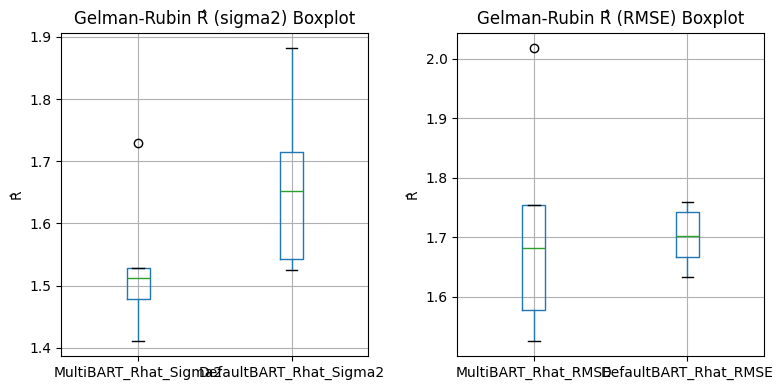

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

# sigma2 boxplot
rhat_df[["MultiBART_Rhat_Sigma2", "DefaultBART_Rhat_Sigma2"]].boxplot(ax=axes[0])
axes[0].set_title("Gelman-Rubin R̂ (sigma2) Boxplot")
axes[0].set_ylabel("R̂")

# rmse boxplot
rhat_df[["MultiBART_Rhat_RMSE", "DefaultBART_Rhat_RMSE"]].boxplot(ax=axes[1])
axes[1].set_title("Gelman-Rubin R̂ (RMSE) Boxplot")
axes[1].set_ylabel("R̂")

plt.tight_layout()
plt.show()

test_mse:
      bart_mtmh      bart       btz        rf       xgb
0      0.210202  0.220808  0.284305  0.272077  0.218599
1      0.222350  0.227810  0.289723  0.261053  0.217833
2      0.224496  0.233558  0.290290  0.262780  0.226877
3      0.204164  0.211569  0.273101  0.244403  0.213037
4      0.216044  0.228576  0.277822  0.265763  0.223567
5      0.219813  0.221952  0.282850  0.256011  0.223564
6      0.217108  0.228216  0.285769  0.266254  0.228732
7      0.220715  0.224067  0.292375  0.272183  0.226946
8      0.218733  0.233533  0.283058  0.258861  0.219225
9      0.213808  0.221989  0.288779  0.250178  0.214931
mean   0.216743  0.225208  0.284807  0.260956  0.221331
std    0.006064  0.006615  0.005974  0.008964  0.005385



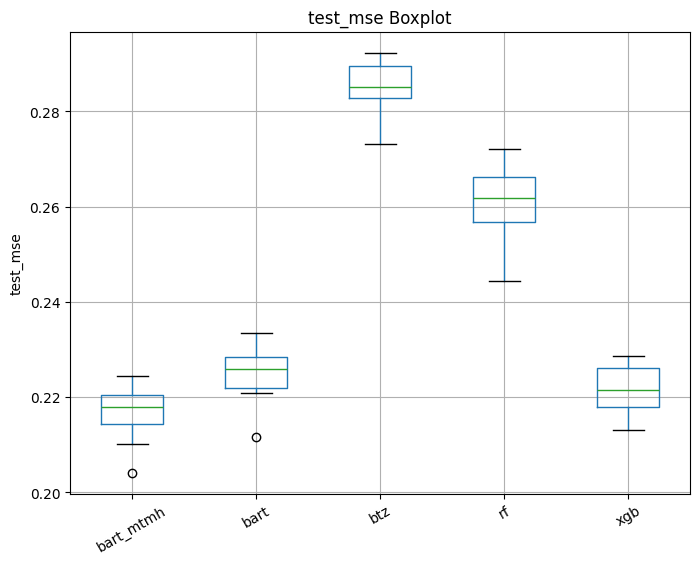

train_mse:
      bart_mtmh      bart       btz        rf       xgb
0      0.142065  0.174678  0.264529  0.036417  0.070528
1      0.147501  0.173069  0.259645  0.036316  0.071458
2      0.143205  0.172521  0.252435  0.035701  0.067329
3      0.147911  0.176445  0.259378  0.036103  0.072052
4      0.147091  0.176718  0.256427  0.034991  0.072937
5      0.140586  0.168189  0.264643  0.036166  0.067958
6      0.146121  0.177635  0.255568  0.035877  0.070881
7      0.140799  0.171869  0.257327  0.036120  0.072070
8      0.142062  0.172123  0.254505  0.035792  0.069747
9      0.140732  0.172277  0.250741  0.035288  0.072473
mean   0.143807  0.173552  0.257520  0.035877  0.070743
std    0.003018  0.002846  0.004640  0.000453  0.001893



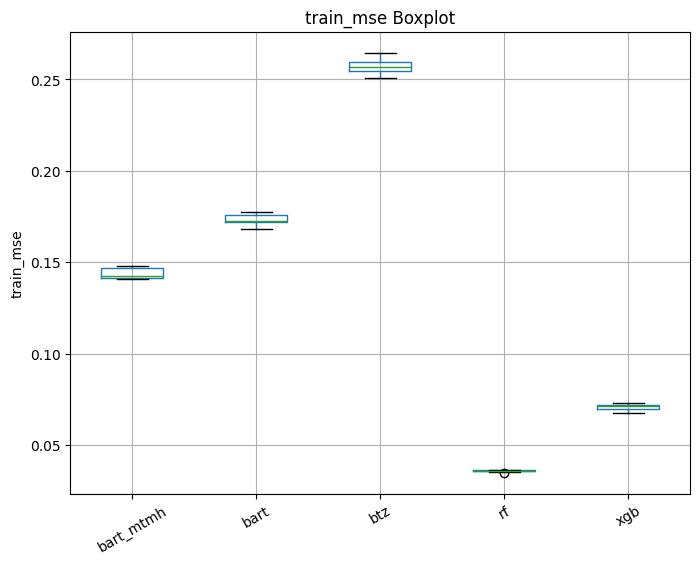

pi_length:
      bart_mtmh      bart       btz
0      1.568114  1.707358  2.167440
1      1.586130  1.691926  2.180984
2      1.572448  1.693551  2.149162
3      1.596266  1.703181  2.166198
4      1.579642  1.710936  2.160843
5      1.556151  1.682897  2.201294
6      1.593689  1.710267  2.165838
7      1.548164  1.695076  2.150492
8      1.572103  1.690308  2.118281
9      1.557215  1.688216  2.147927
mean   1.572992  1.697372  2.160846
std    0.016196  0.009869  0.022013



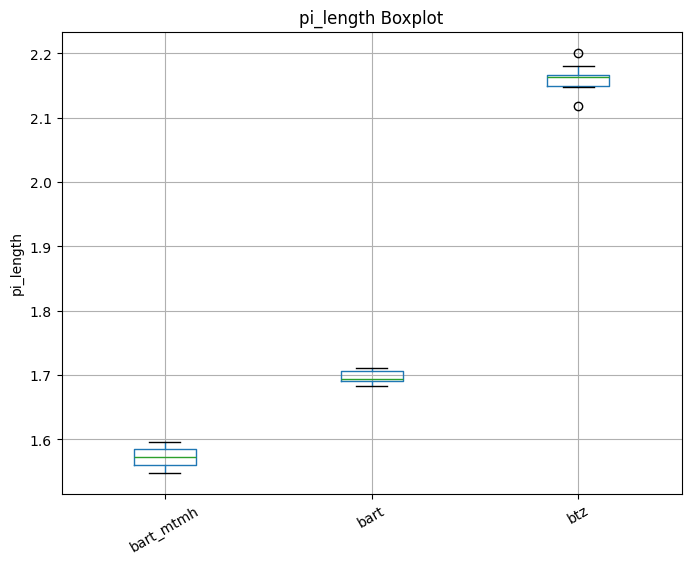

coverage:
      bart_mtmh      bart       btz
0      0.925581  0.931395  0.950581
1      0.928682  0.934690  0.948643
2      0.923450  0.931008  0.945930
3      0.932364  0.934690  0.949419
4      0.928295  0.936434  0.952713
5      0.918217  0.931395  0.948256
6      0.928488  0.933333  0.949612
7      0.918798  0.930620  0.943992
8      0.921705  0.928682  0.945155
9      0.924225  0.931202  0.946124
mean   0.924981  0.932345  0.948043
std    0.004588  0.002357  0.002706



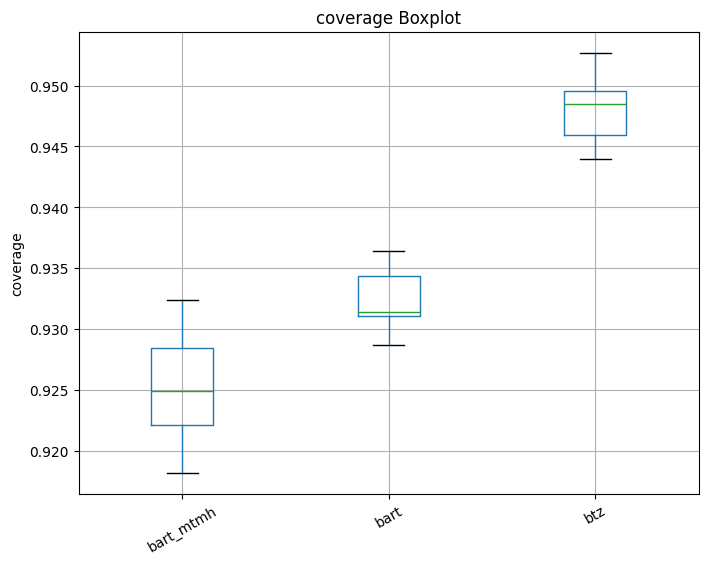

train_time:
       bart_mtmh       bart        btz         rf       xgb
0     443.434185  80.409832  52.723784  12.072392  0.327205
1     436.128766  72.759288  49.527848  20.316283  0.622772
2     447.396860  75.190314  51.805664  12.193768  0.537756
3     448.153197  76.216195  53.239538  11.707129  0.268870
4     447.576729  74.948939  51.955926  12.258952  0.522242
5     440.456775  77.322292  42.688392  17.297721  0.236135
6     454.672976  95.918196  41.218389  11.842073  0.118796
7     433.806772  70.485782  42.544262  16.987501  0.213688
8     443.996162  82.205423  44.876952  13.244677  0.147170
9     442.742222  81.738634  45.910869  13.239842  0.142788
mean  443.836464  78.719489  47.649162  14.116034  0.313742
std     6.105922   7.134645   4.703299   2.993188  0.183290



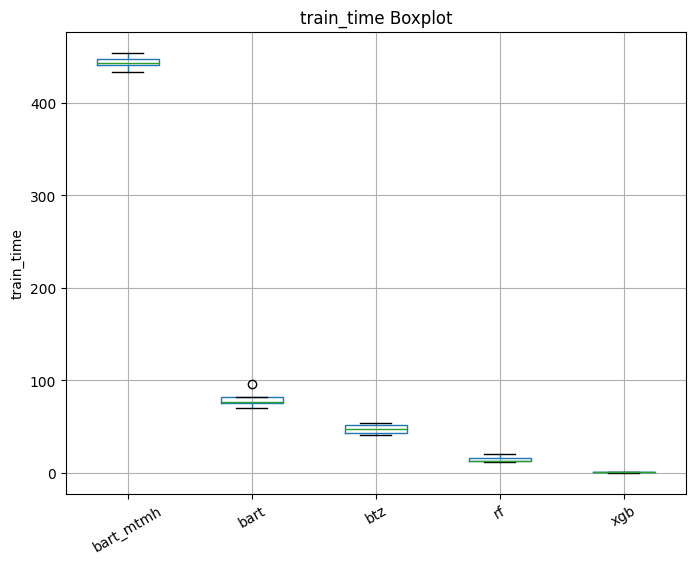

In [14]:
import matplotlib.pyplot as plt
import comparison
import pandas as pd

mse_results = comparison.bart_mse_comparison(X, y, n_runs=10, n_skip=1000, n_post=1000, n_trees=100, n_jobs=5)
for k, v in mse_results.items():
    mean_row = pd.DataFrame([v.mean()], index=["mean"])
    std_row = pd.DataFrame([v.std()], index=["std"])
    v_with_stats = pd.concat([v, mean_row, std_row])
    print(f"{k}:\n{v_with_stats}\n")
    
    plt.figure(figsize=(8, 6))
    v.boxplot()
    plt.title(f"{k} Boxplot")
    plt.ylabel(k)
    plt.xticks(rotation=30)
    plt.show()

In [15]:
for k, v in mse_results.items():
    csv_name = f"results/real3_CalHousing_{k}.csv"
    v.to_csv(csv_name, index=False)

## Multi-tries

In [16]:
from multi_tries import multi_tries_performance
import pandas as pd

csv_path = "results/real3_CalHousing_tries.csv"
existing_df = None

if os.path.exists(csv_path):
    existing_df = pd.read_csv(csv_path)

df = multi_tries_performance(
    X, y,
    multi_tries_list=[1, 5, 10, 50],
    n_runs=5, n_chains=4,
    ndpost=1000, nskip=1000, n_trees=100, n_jobs=5
)

if existing_df is not None:
    df = pd.concat([existing_df, df], ignore_index=True)
    df = df.sort_values(by='multi_tries', ascending=True).reset_index(drop=True)

df.to_csv("results/real3_CalHousing_tries.csv", index=False)

In [17]:
df = pd.read_csv("results/real3_CalHousing_tries.csv")
print(df)

   multi_tries  Rhat_Sigma2  Rhat_RMSE  Test_MSE  Coverage   Train_Time
0            1     1.602325   1.960823  0.223089  0.934109   125.266718
1            5     1.595627   1.609658  0.218184  0.929535   287.391389
2           10     1.531820   1.711494  0.213891  0.926667   467.641404
3           50     1.616604   1.690688  0.214135  0.922791  1739.155676
